<a href="https://colab.research.google.com/github/yumkim1016/TP1/blob/main/Regression_data_sumup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [회귀모델] 전복나이 구하기

##0. 들어가기에 앞서..  

  나무에 1년에 한 개씩 생기는 '나이테'로 사람들이 나무의 나이를 추정하듯, 전복 또한 껍데기에 1년에 1개씩 아래의 사진처럼 갈색줄이 생기는 데, 이를 'Ring', 즉 고리라고 합니다. 이 고리의 갯수로 전복의 나이를 추정할 수 있는 데, 전복의 크기가 크다고해서 무조건 고리가 많은 것도, 작다고해서 아직 어린 것도 아닐 수 있다고 합니다. 다만, 크기가 커지는 데에 시간이 들 수 밖에 없는 것 처럼, **전복 껍데기의 크기가 클 수록 나이가 많을 확률은 분명하게 올라갑니다.**



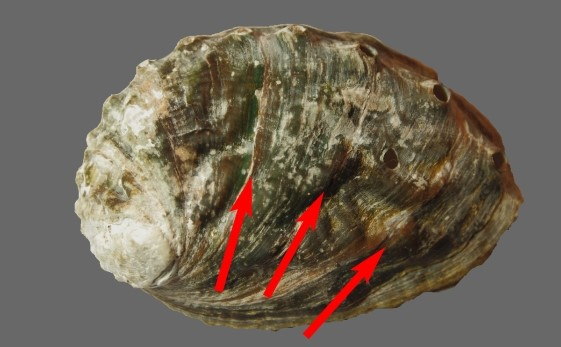

 
  이렇게 크기와 나이가 연관이 있을 수 있는 것 처럼, 전복에는 크기 외에도 나이를 추정할 수 있는 여러가지 특성이 있습니다.      
  우리는 해당 특성들을 가지고 전복의 나이를 추정하는 모델을 개발하였으며, 이번 프로젝트로 기존 모델의 성능을 고도화 시켰습니다.

## 1. 데이터 소개

- 데이터 수: 전처리 전 4,177개, 전처리 후 4,015개     

- 특성(feature): 8개     
  - Sex: 전복의 성별(F, M, I(Infant 유아 = 성별구분이 없음)) / dtype: object
  - Length: 전복 껍데기의 길이 / dtype: float
  - Diameter: 전복 껍데기의 지름 / dtype: float
  - Height: 전복 껍데기의 높이 / dtype: float
  - Whole Weight: 전복 전체 무게 / dtype: float
  - Shucked Weight: 껍데기를 제외한 무게 / dtype: float
  - Viscera Weight: 내장 무게 / dtype: float
  - Shell Weight: 껍데기 무게 / dtype: float

- 타겟(target): 1개
  - Rings: 전복 껍데기에 있는 고리의 갯수(= 전복의 나이) / dtype: int

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('Regression_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


## 2. 데이터 전처리 및 EDA

### 기본검사

In [4]:
# 결측치 검사
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
# 중복데이터 검사
df.duplicated().sum()

0

In [6]:
# 통계치 검사
df.describe()
# Height: min값 0 발견
# Height: 75% 0.165 -> max 1.130 이상치 발견
# 기타 weight특성들에서도 75%와 max값의 갭이 큼, 데이터 확인 필요

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [7]:
# 명목형 데이터 오탈자 검사
df.Sex.value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

In [8]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Encoding
명목형 데이터의 경우 One-Hot Encoding, Label Encoding 등으로 숫자로의 변환이 필요하다.      
변환하려는 성별 데이터의 경우는 숫자의 크기가 영향이 있지 않으므로, 단순 Label Encoding으로 진행해도 무관하여 간단하게 진행하였다.

In [9]:
encoder = LabelEncoder()
df['Sex_Encoded'] = encoder.fit_transform(df['Sex'])
print(df)

     Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0      M   0.455     0.365   0.095        0.5140          0.2245   
1      M   0.350     0.265   0.090        0.2255          0.0995   
2      F   0.530     0.420   0.135        0.6770          0.2565   
3      M   0.440     0.365   0.125        0.5160          0.2155   
4      I   0.330     0.255   0.080        0.2050          0.0895   
...   ..     ...       ...     ...           ...             ...   
4172   F   0.565     0.450   0.165        0.8870          0.3700   
4173   M   0.590     0.440   0.135        0.9660          0.4390   
4174   M   0.600     0.475   0.205        1.1760          0.5255   
4175   F   0.625     0.485   0.150        1.0945          0.5310   
4176   M   0.710     0.555   0.195        1.9485          0.9455   

      Viscera weight  Shell weight  Rings  Sex_Encoded  
0             0.1010        0.1500     15            2  
1             0.0485        0.0700      7            2  
2           

In [10]:
print('Encoded Values:', df['Sex_Encoded'].unique())
print('Mapping:')
for i, label in enumerate(encoder.classes_):
    print(f'{label} -> {i}')

Encoded Values: [2 0 1]
Mapping:
F -> 0
I -> 1
M -> 2


In [11]:
# column 위치 재정렬(target을 끝 column으로 가져가기 위함)
df = df.reindex(columns=['Sex_Encoded', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'])

### 이상치 체크리스트 
1. Whole weight이 Shucked + Shell 보다 작을 수 없다. 
  -> Whole weight를 Shucked + Viscera + Shell 값으로 고쳐준다.   
2. Whole weight이 Shucked, Viscera, Shell 무게 셋 중에 하나보다 작을 수 없다.  -> Whole weight를 Shucked + Viscera + Shell 값으로 고쳐준다.  
3. Height가 0일 수 없다.(통계치 검사에서 0 있음 확인) -> Length와 Diameter이 비슷한 수치를 찾아 비슷한 값으로 대체한다.


↓ 1. Whole weight이 Shucked + Shell 보다 작을 수 없다. 
  -> Whole weight를 Shucked + Viscera + Shell 값으로 고쳐준다.  

In [12]:
# 데이터확인
df[df['Whole weight']<df['Shucked weight']+df['Shell weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
193,1,0.355,0.275,0.085,0.2200,0.0920,0.0600,0.1500,8
236,1,0.075,0.055,0.010,0.0020,0.0010,0.0005,0.0015,1
822,1,0.380,0.275,0.095,0.1375,0.0860,0.0585,0.0605,7
1216,1,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5
1219,1,0.325,0.225,0.075,0.1390,0.0565,0.0320,0.0900,6
1264,1,0.455,0.330,0.100,0.3720,0.3580,0.0775,0.1100,8
1302,1,0.535,0.415,0.150,0.5765,0.3595,0.1350,0.2250,8
1430,1,0.230,0.165,0.060,0.0515,0.0190,0.0145,0.0360,4
2127,1,0.400,0.310,0.100,0.1270,0.1060,0.0710,0.0850,7
2627,1,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5


In [13]:
# 데이터 수정 및 재호출하여 변경확인
df.loc[df['Whole weight'] < df['Shucked weight'] + df['Shell weight'], 'Whole weight'] = df['Shucked weight'] + df['Viscera weight'] + df['Shell weight']
df[df['Whole weight']<df['Shucked weight']+df['Shell weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


↓ 2. Whole weight이 Shucked, Viscera, Shell 무게 셋 중에 하나보다 작을 수 없다.  -> Whole weight를 Shucked + Viscera + Shell 값으로 고쳐준다.  

In [14]:
# Whole 이 Shucked 보다 작은 데이터 확인
df[df['Whole weight']<df['Shucked weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [15]:
# Whole 이 Viscera 보다 작은 데이터 확인
df[df['Whole weight']<df['Viscera weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [16]:
# Whole 이 Shell 보다 작은 데이터 확인
df[df['Whole weight']<df['Shell weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [17]:
# 위 해당 row들 Whole weight 고치기
df.loc[df['Whole weight'] < df['Shucked weight'], 'Whole weight'] = df['Shucked weight'] + df['Viscera weight'] + df['Shell weight']
df.loc[df['Whole weight'] < df['Shell weight'], 'Whole weight'] = df['Shucked weight'] + df['Viscera weight'] + df['Shell weight']

In [18]:
# 재호출하여 변경확인
df[df['Whole weight']<df['Shucked weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [19]:
# 재호출하여 변경확인
df[df['Whole weight']<df['Shell weight']]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [20]:
# 데이터 수 확인
df.shape

(4177, 9)

↓ 3. Height가 0일 수 없다.(통계치 검사에서 0 있음 확인) -> Length와 Diameter이 비슷한 수치를 찾아 비슷한 값으로 대체한다.

In [21]:
# Height가 0인 row 확인
df[df['Height']==0]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,1,0.430,0.34,0.0,0.4280,0.2065,0.0860,0.1150,8
3996,1,0.315,0.23,0.0,0.4365,0.0575,0.0285,0.3505,6


In [22]:
# 유사한 Length와 Diameter를 가진 Height로 수정
for index, row in df.iterrows():
    if row['Height'] == 0:
        similar_rows = df[(df['Length'] == row['Length']) & (df['Diameter'] == row['Diameter'])]
        if not similar_rows.empty:
            df.at[index, 'Height'] = similar_rows['Height'].values[0]

In [23]:
# 해당 row 호출하여 변경확인
df.loc[1257:1257]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,1,0.43,0.34,0.12,0.428,0.2065,0.086,0.115,8


In [24]:
df.loc[3996:3996]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
3996,1,0.315,0.23,0.09,0.4365,0.0575,0.0285,0.3505,6


In [25]:
# 재호출하여 더블체크
df[df['Height']==0]

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings


In [26]:
# 데이터 수 확인
df.shape

(4177, 9)

In [27]:
# 데이터 통계치 재확인
df.describe()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,1.052909,0.523992,0.407881,0.139567,0.829424,0.359367,0.180594,0.238831,9.933684
std,0.822240,0.120093,0.099240,0.041724,0.489950,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.010000,0.003000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.442500,0.186000,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


### Outlier Checking

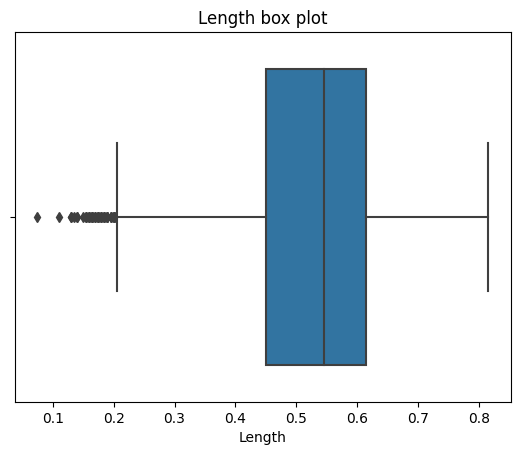

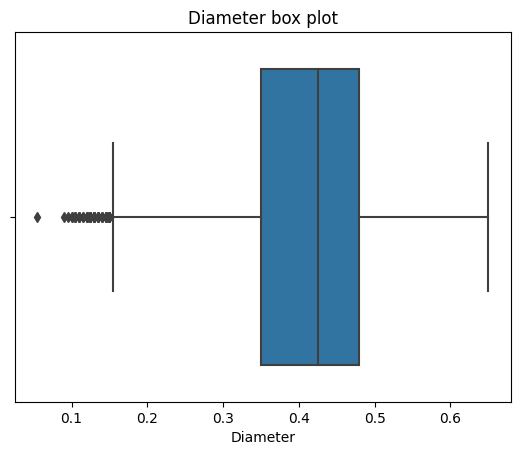

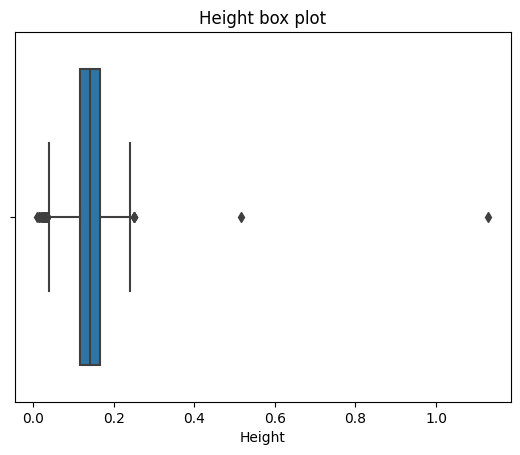

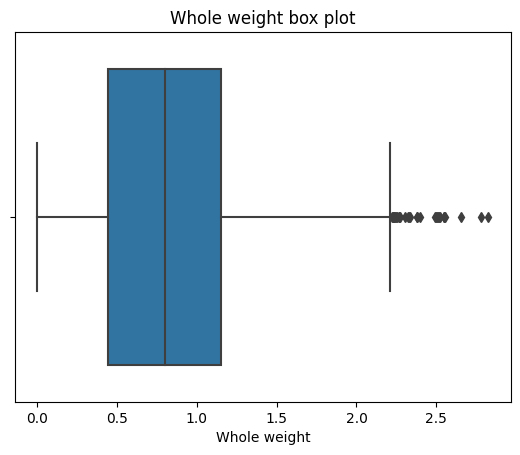

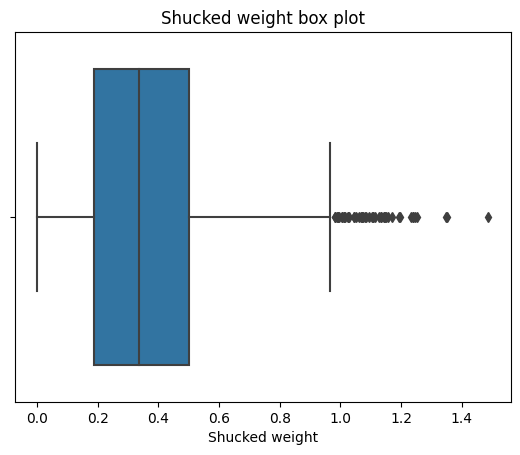

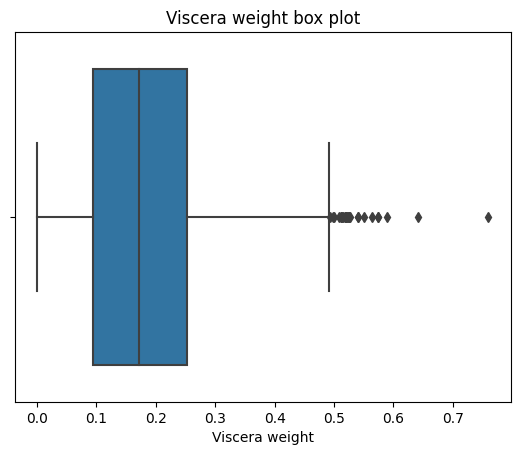

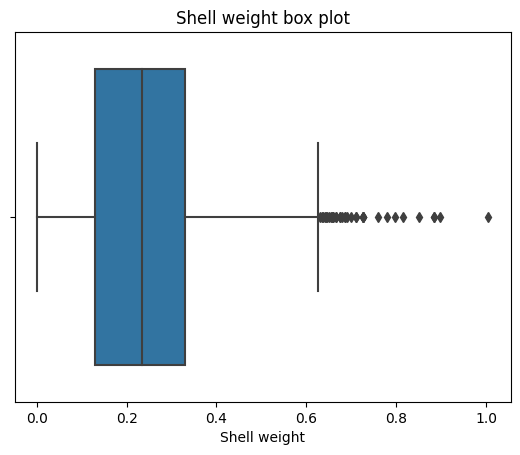

In [28]:
def feature_boxplot(data,feature):
    plt.title(f'{feature} box plot')
    sns.boxplot(x = data[feature])
    return plt.show()

for column in df.columns[1:-1]:
    feature_boxplot(df,column)

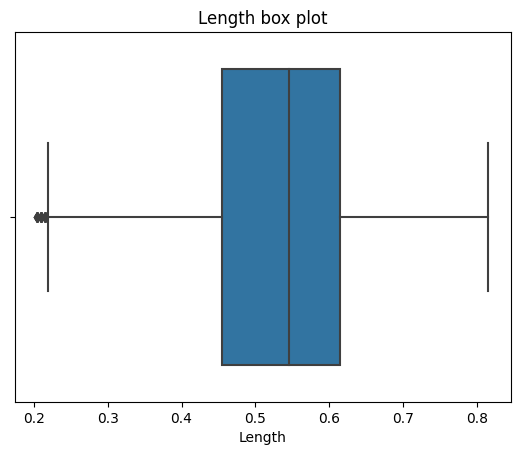

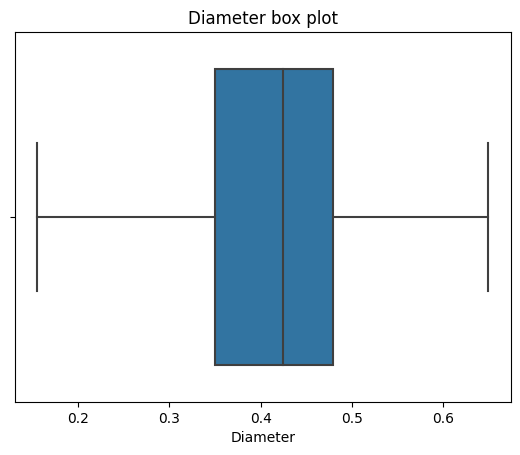

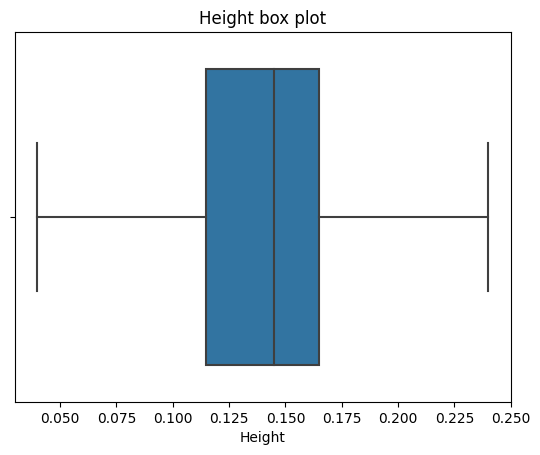

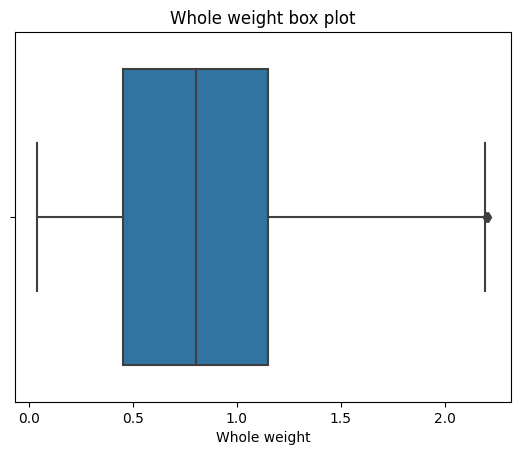

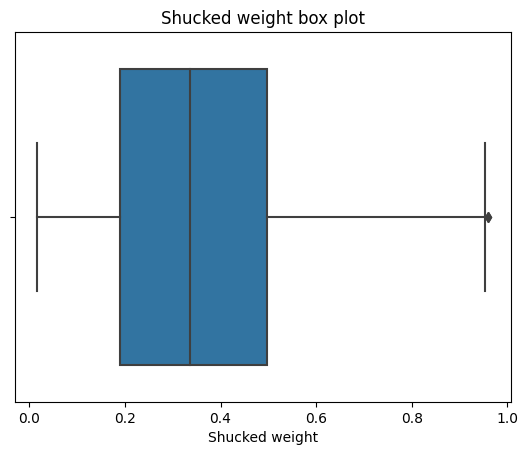

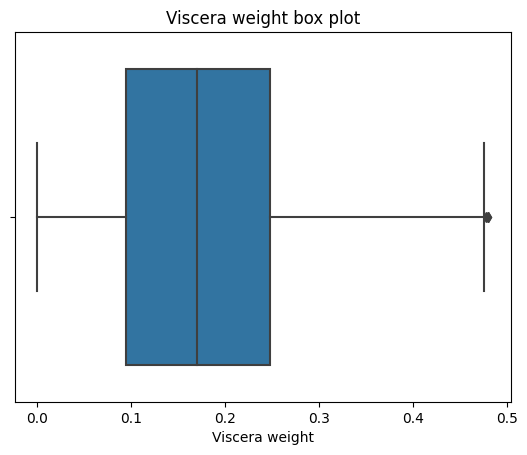

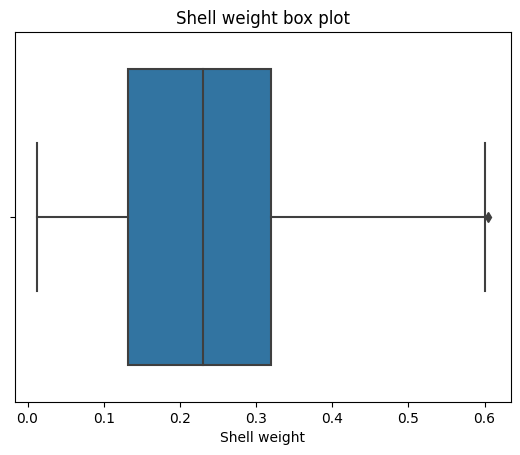

In [29]:
# 아웃라이어 제거 함수 정의
def remove_outliers(data, feature, fence_factor=1.5):
  Q1 = data[feature].quantile(0.25)
  Q3 = data[feature].quantile(0.75)
  IQR = Q3 - Q1
  lower_fence = Q1 - fence_factor * IQR
  upper_fence = Q3 + fence_factor * IQR
  filtered_data = data[(data[feature] >= lower_fence) & (data[feature] <= upper_fence)]
  return filtered_data

# 아웃라이어 제거 적용
for column in df.columns[1:-1]:
  df = remove_outliers(df, column, fence_factor=1.5)
  feature_boxplot(df,column)

In [30]:
# Outlier 제거 후 shape변화
print(df.shape)

(4015, 9)


### 가설리스트

- 편의상 균일한 타원형 반구라는 가정 및 
- 빈 속이 전체의 50%라고 임의로 가정한다.

전복 껍데기가 성장하는데에는 시간이 걸리기 때문에,  

- `가설 1` 전복 껍데기의 부피가 타겟과 관련이 있을 것이다.     
  - 부피: (4/3) * π * a * b * c * 1/2(반구) * 50%(빈 속 제외)
- `가설 2` 전복 껍데기의 밀도가 타겟과 관련이 있을 것이다.
  - 밀도: 무게(Shell weight) / 부피

해당 가설들을 기반으로 'Volume', 'Density' feature들을 추가해본다.

In [31]:
# features 추가 및 reindex(target을 끝 column으로 가져가기 위함)
df['Volume'] = 4/3 * math.pi * df['Length'] * df['Diameter'] * df['Height'] * 1/2 * 1/2
df['Density'] = df['Shell weight'] / df['Volume']
df = df.reindex(columns=['Sex_Encoded', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Volume', 'Density', 'Rings'])

In [32]:
df.head()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.016522,9.078932,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.008741,8.007796,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.031469,6.673163,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.021022,7.373056,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.007050,7.801713,7


In [33]:
# 데이터 저장 reg_df
reg_df = df
reg_df.to_csv('reg_df.csv', index=False)

In [34]:
df.describe()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
count,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000
mean,1.049813,0.524457,0.408181,0.139073,0.809925,0.350762,0.176699,0.233436,0.035556,6.836209,9.941469
std,0.822582,0.110543,0.091785,0.035589,0.444648,0.201006,0.100650,0.125745,0.020169,1.374386,3.117498
min,0.000000,0.205000,0.155000,0.040000,0.042500,0.017000,0.000500,0.013000,0.001497,2.618939,3.000000
25%,0.000000,0.450000,0.350000,0.115000,0.448250,0.188750,0.094750,0.131500,0.019084,6.057529,8.000000
50%,1.000000,0.540000,0.420000,0.140000,0.794000,0.333500,0.169000,0.230000,0.034119,6.655730,9.000000
75%,2.000000,0.610000,0.480000,0.165000,1.133000,0.493250,0.246500,0.320000,0.050081,7.378444,11.000000
max,2.000000,0.760000,0.600000,0.240000,2.127500,0.960000,0.480500,0.605000,0.102176,51.330856,29.000000


### Scaling(Min-Max, Standardization 2종류 사용)

In [35]:
# 데이터 별도 저장하여 성능 높은걸로 사용
reg_minmax = df.copy()
reg_standard = df.copy()

features_to_scale = list(df.columns[1:-1]) #Sex_Encoded과 target인 Rings는 Scaling되면 안됨!

In [36]:
# Min-Max Scaling(Normalization)
scaler = MinMaxScaler()
reg_minmax[features_to_scale] = scaler.fit_transform(df[features_to_scale])
reg_minmax.describe()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
count,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000,4015.000000
mean,1.049813,0.575598,0.568945,0.495367,0.368070,0.353936,0.367082,0.372359,0.338289,0.086576,9.941469
std,0.822582,0.199177,0.206259,0.177946,0.213261,0.213155,0.209687,0.212407,0.200327,0.028215,3.117498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,0.441441,0.438202,0.375000,0.194604,0.182131,0.196354,0.200169,0.174684,0.070590,8.000000
50%,1.000000,0.603604,0.595506,0.500000,0.360432,0.335631,0.351042,0.366554,0.324019,0.082871,9.000000
75%,2.000000,0.729730,0.730337,0.625000,0.523022,0.505037,0.512500,0.518581,0.482561,0.097707,11.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.000000


In [37]:
# StandardScaler
scaler = StandardScaler()
reg_standard[features_to_scale] = scaler.fit_transform(df[features_to_scale])
reg_standard.describe()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
count,4015.000000,4.015000e+03,4.015000e+03,4.015000e+03,4.015000e+03,4.015000e+03,4.015000e+03,4.015000e+03,4.015000e+03,4.015000e+03,4015.000000
mean,1.049813,6.937304e-16,-2.743067e-16,3.964174e-16,-5.309161e-18,8.140714e-17,2.459911e-16,-2.176756e-16,8.494658e-17,2.778461e-16,9.941469
std,0.822582,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,3.117498
min,0.000000,-2.890244e+00,-2.758751e+00,-2.784152e+00,-1.726131e+00,-1.660666e+00,-1.750838e+00,-1.753260e+00,-1.688898e+00,-3.068857e+00,3.000000
25%,0.000000,-6.736399e-01,-6.339574e-01,-6.765102e-01,-8.134977e-01,-8.061058e-01,-8.143042e-01,-8.107598e-01,-8.167919e-01,-5.666358e-01,8.000000
50%,1.000000,1.406229e-01,1.287889e-01,2.603712e-02,-3.581992e-02,-8.588655e-02,-7.650395e-02,-2.733142e-02,-7.124219e-02,-1.313321e-01,9.000000
75%,2.000000,7.739384e-01,7.825715e-01,7.285845e-01,7.266755e-01,7.089668e-01,6.935905e-01,6.884914e-01,7.202772e-01,3.945780e-01,11.000000
max,2.000000,2.131043e+00,2.090137e+00,2.836227e+00,2.963554e+00,3.031332e+00,3.018779e+00,2.955264e+00,3.303575e+00,3.237823e+01,29.000000


In [38]:
# 데이터 저장 reg_minmax, reg_standard

reg_minmax.to_csv('reg_minmax.csv', index=False)
reg_standard.to_csv('reg_standard.csv', index=False)

### Feature importance / heatmap (스케일링 미진행 데이터)




In [39]:
# Feature Importance

features = df[df.columns[:-1]]
target = df['Rings']

# 랜덤 포레스트 분류기 모델 생성
rf = RandomForestClassifier(random_state=42)
rf.fit(features, target)

# Feature importance 계산
importances = rf.feature_importances_

# 결과 출력
for feature, importance in zip(features.columns, importances):
    print(f'{feature}: {importance}')

Sex_Encoded: 0.034367103340249616
Length: 0.08622005158186995
Diameter: 0.08621962338897862
Height: 0.07083800870627091
Whole weight: 0.11536386074625969
Shucked weight: 0.12743782977289195
Viscera weight: 0.12061984988577822
Shell weight: 0.12558623665724314
Volume: 0.11661606768917451
Density: 0.11673136823128347


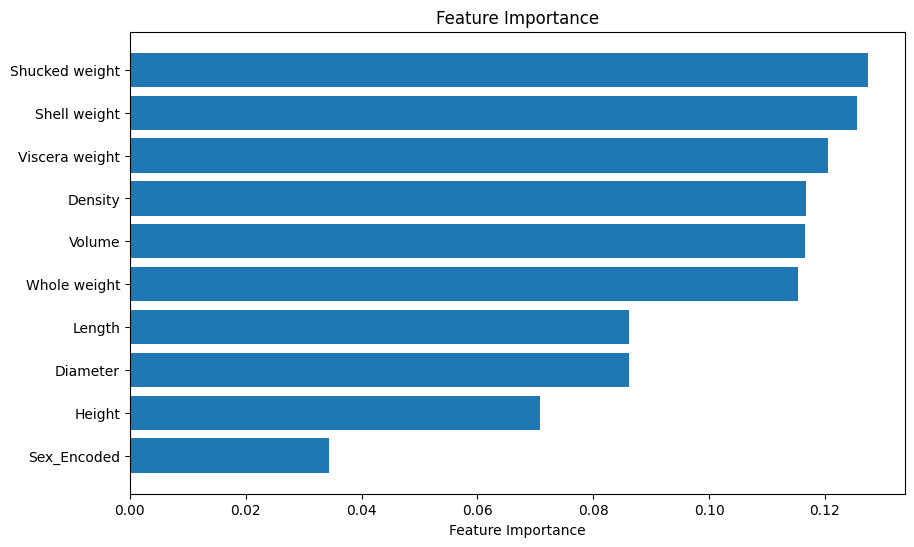

In [40]:
# bar plot으로 결과 시각화, 높은순서대로 표시

feature_names = features.columns
sorted_indices = np.argsort(importances)
pos = np.arange(sorted_indices.shape[0]) + 0.5

plt.figure(figsize=(10, 6))
plt.barh(pos, importances[sorted_indices], align='center')
plt.yticks(pos, feature_names[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

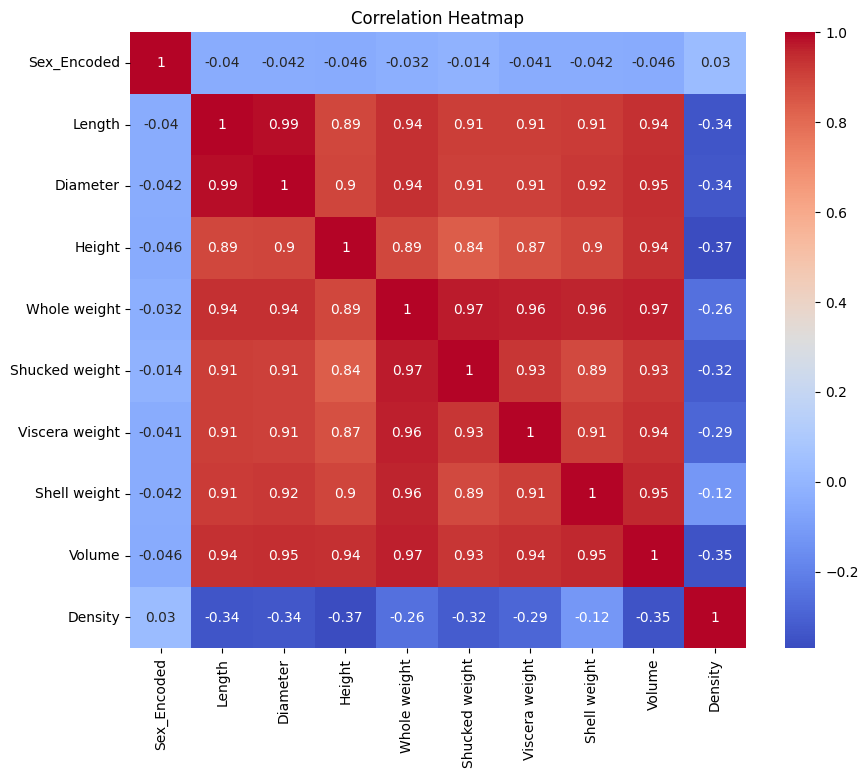

In [41]:
# Heatmap

# 상관관계 계산
correlation_matrix = features.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [42]:
# 가장 연관성 없어보이는 Sex_Encoded, Density features drop
reg_fi = df.drop('Density', axis=1)
reg_fi = df.drop('Sex_Encoded', axis=1)

In [43]:
# 데이터 저장 reg_fi

reg_fi.to_csv('reg_fi.csv', index=False)

### PCA (스케일링 미진행 데이터)

In [44]:
df.head()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.016522,9.078932,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.008741,8.007796,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.031469,6.673163,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.021022,7.373056,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.007050,7.801713,7


In [45]:
# 엔코딩된 성별 feature이 있으니, 기존 성별 feature 삭제
# df = df.drop('Sex', axis=1)
# df.head()

In [46]:
# PCA는 독립변수만을 위한 작업이니, target 삭제
df_pca = df.drop('Rings', axis=1)
df_pca

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0.016522,9.078932
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0.008741,8.007796
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,0.031469,6.673163
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0.021022,7.373056
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0.007050,7.801713
...,...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,0.043931,5.667948
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0.036700,7.098076
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0.061183,5.034118
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,0.047615,6.216559


In [47]:
# 모든 독립변수 개수(10개) 만큼 주성분 개수 설정해서 분석하기
pca = PCA(n_components=10)
pca_array = pca.fit_transform(df_pca)
pca_df = pd.DataFrame(pca_array, index=df_pca.index,
                       columns=[f"pca{num+1}"for num in range(pca.n_components)])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10
0,2.294618,-0.886560,-0.064304,0.013484,0.039041,0.015054,0.017046,-0.003960,-0.015049,0.000366
1,1.274039,-0.926855,-0.541770,0.031488,-0.024660,-0.001318,-0.003316,0.000300,-0.001133,0.001467
2,-0.173479,1.041250,-0.197966,-0.054519,0.022643,0.001308,0.015385,0.000554,-0.005124,-0.000166
3,0.601764,-0.939595,-0.264024,-0.007645,-0.003019,0.002039,-0.001460,0.011149,-0.019192,-0.002340
4,1.044736,0.065363,-0.620966,0.047917,-0.036749,-0.005772,0.003946,-0.004936,-0.006926,0.001867


In [48]:
# 주성분의 설명력과 기여율 구하기
result = pd.DataFrame({'설명가능한 분산비율(고윳값)':pca.explained_variance_, 
                       '기여율': pca.explained_variance_ratio_}, index = np.array([f"pca{num+1}" for num in range(pca.n_components)]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산비율(고윳값),기여율,누적기여율
pca1,1.913825,0.671058,0.671058
pca2,0.675863,0.236983,0.908040
pca3,0.256217,0.089839,0.997879
pca4,0.002978,0.001044,0.998924
pca5,0.001654,0.000580,0.999504
pca6,0.000773,0.000271,0.999774
pca7,0.000353,0.000124,0.999898
pca8,0.000144,0.000051,0.999949
pca9,0.000136,0.000048,0.999997
pca10,0.000010,0.000003,1.000000


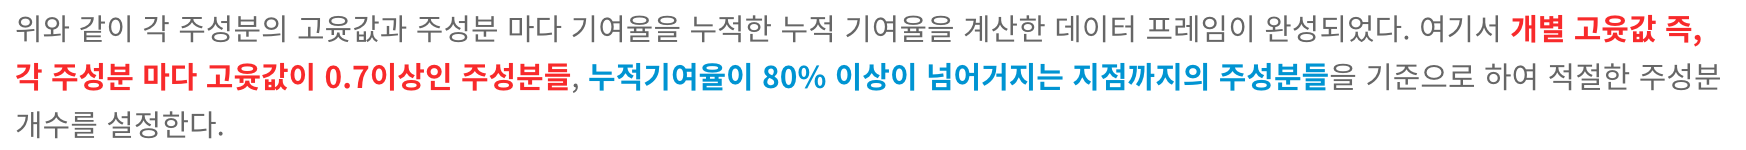

따라서, 2개의 주성분으로 PCA를 수행해주면 좋다.

In [49]:
df.shape

(4015, 11)

In [50]:
df.head()

,Sex_Encoded,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Volume,Density,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.016522,9.078932,15
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.008741,8.007796,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.031469,6.673163,9
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.021022,7.373056,10
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.007050,7.801713,7


In [51]:
pca = PCA(n_components=2)
pca_array = pca.fit_transform(df_pca)
pca_df = pd.DataFrame(pca_array, index=df_pca.index,
                       columns=[f"pca{num+1}"for num in range(pca.n_components)])
pca_df.head()

,pca1,pca2
0,2.294618,-0.886560
1,1.274039,-0.926855
2,-0.173479,1.041250
3,0.601764,-0.939595
4,1.044736,0.065363


In [52]:
pca_df['Rings'] = df['Rings']

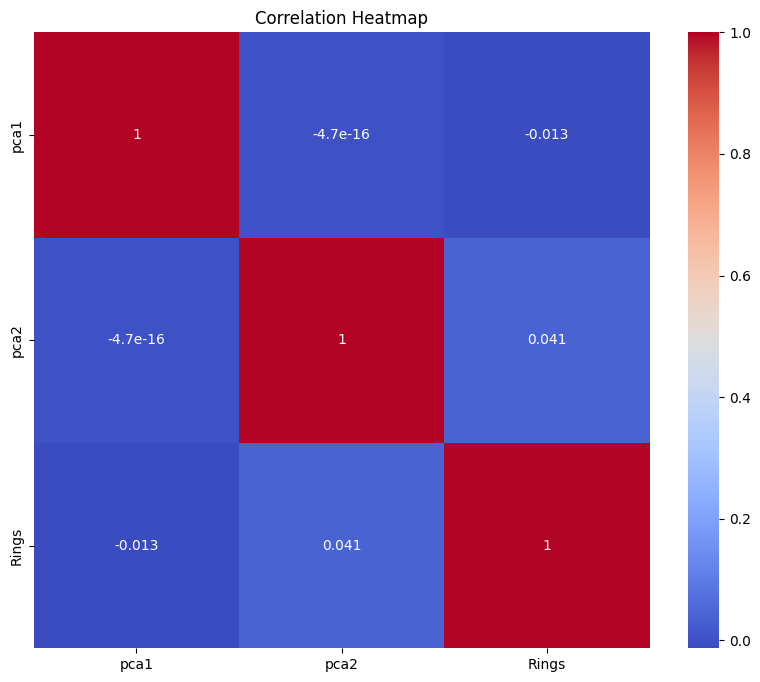

In [53]:
# Heatmap

# 상관관계 계산
features = pca_df
correlation_matrix = features.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [54]:
reg_pca = pca_df

In [55]:
# 데이터 저장 reg_pca

reg_pca.to_csv('reg_pca.csv', index=False)